# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Load-Data" data-toc-modified-id="Load-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load Data</a></div><div class="lev1 toc-item"><a href="#Word-Segmentation" data-toc-modified-id="Word-Segmentation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Word Segmentation</a></div><div class="lev1 toc-item"><a href="#Tokenize-Text" data-toc-modified-id="Tokenize-Text-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Tokenize Text</a></div><div class="lev1 toc-item"><a href="#Word-Embedding" data-toc-modified-id="Word-Embedding-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Word Embedding</a></div><div class="lev2 toc-item"><a href="#Read-Pretrained-Model" data-toc-modified-id="Read-Pretrained-Model-41"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Read Pretrained Model</a></div><div class="lev2 toc-item"><a href="#Use-Word2vec-to-Initialize-Embedding-Matrix" data-toc-modified-id="Use-Word2vec-to-Initialize-Embedding-Matrix-42"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Use Word2vec to Initialize Embedding Matrix</a></div><div class="lev1 toc-item"><a href="#Build-Dateset" data-toc-modified-id="Build-Dateset-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Build Dateset</a></div><div class="lev1 toc-item"><a href="#Build-Model" data-toc-modified-id="Build-Model-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Build Model</a></div><div class="lev2 toc-item"><a href="#Import-Libraries" data-toc-modified-id="Import-Libraries-61"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Import Libraries</a></div><div class="lev2 toc-item"><a href="#Model-Visualization" data-toc-modified-id="Model-Visualization-62"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Model Visualization</a></div><div class="lev2 toc-item"><a href="#Train" data-toc-modified-id="Train-63"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Train</a></div><div class="lev1 toc-item"><a href="#Evaluate" data-toc-modified-id="Evaluate-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Evaluate</a></div>

# Load Data

In [20]:
import json
import os

In [21]:
def load_data(path, name):
    """
    Load date from file
    """
    data = []
    input_file = os.path.join(path)
    with open(input_file) as f:
        lines = f.readlines()
    for line in lines:
        item = json.loads(line)
        data.append(item[name])
    return data

In [22]:
sentence = load_data('done_data.json', 'sentence')
label = load_data('done_data.json', 'label')

In [23]:
len(sentence)

1696

# Word Segmentation

In [24]:
import jieba
import re
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [25]:
not_cuts = re.compile(u'([\da-zA-Z\.]+)|《(.*?)》|“(.{1,10})”')
re_replace = re.compile(u'[^\u4e00-\u9fa50-9a-zA-Z\%《》\(\)（）“”·\.]')

In [26]:
#filename = "stopwords.txt"
#stopWords = {w: None for w in open(filename).read().split()}

In [27]:
def newcut(s):
    """
    Word Segmentation
    """
    result = []
    j = 0
    s = re_replace.sub(' ', s)
    
    for i in not_cuts.finditer(s):
        result.extend(jieba.lcut(s[j:i.start()], HMM=False))
        if s[i.start()] in [u'《', u'“']:
            result.extend([s[i.start()], s[i.start()+1:i.end()-1], s[i.end()-1]])
        else:
            result.append(s[i.start():i.end()])
        j = i.end()
    result.extend(jieba.lcut(s[j:], HMM=False))
    return result

def clean(s):
    """
    Clean data
    """
    for i in range(len(s)):
        if s[i] == ' ':
            s[i] = None
        if s[i] == '(':
            for j in range(i+1, len(s)):
                if s[j] == ')':
                    for k in range(i, j+1):
                        s[k] = None
        if s[i] == '（':
            for j in range(i+1, len(s)):
                if s[j] == '）':
                    for k in range(i, j+1):
                        s[k] = None
        if s[i] == '《':
            for j in range(i+1, len(s)):
                if s[j] == '》':
                    for k in range(i, j+1):
                        s[k] = None
        if s[i] == '%':
            if s[i-1] != None:
                s[i-1] = s[i-1]+'%'
            s[i] = None   
        if s[i] == '“' or s[i] == '”' or s[i] == '"':
            s[i] = None
    return [i for i in s if i != None]

def del_stop(ws):
    """
    Delete stopwords
    """
    return [i for i in [stopWords.get(i, i) for i in ws] if i != None]

In [28]:
sentWords = [clean(newcut(s)) for s in sentence]

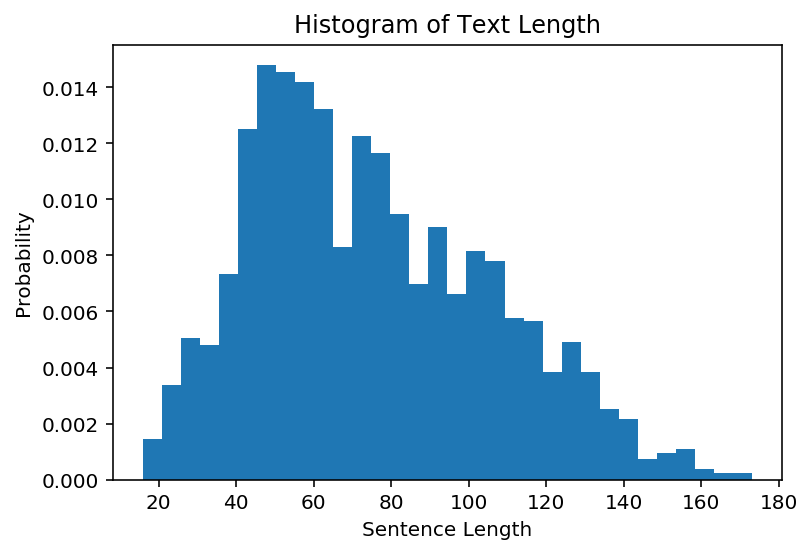

In [29]:
plt.hist([len(i) for i in sentWords], bins=32, normed=True);
plt.xlabel('Sentence Length')
plt.ylabel('Probability')
plt.title('Histogram of Text Length')  

In [30]:
len([' '.join(i) for i in sentWords if len(i)>128])

101

In [31]:
max([len(i) for i in sentWords])

173

In [32]:
min([len(i) for i in sentWords])

16

In [33]:
len(sentWords)

1696

# Tokenize Text

In [34]:
from keras.preprocessing.text import Tokenizer

In [35]:
MAX_LEN = 128

In [38]:
tokWords = sentWords.copy()
tokTexts = [' '.join(i) for i in tokWords]
tokenizer = Tokenizer(filters='')
tokenizer.fit_on_texts(tokTexts)
word2index = tokenizer.word_index
index2word = {i: w for w, i in word2index.items()}
print('Found %s unique tokens.' % len(word2index))

Found 14868 unique tokens.


# Word Embedding

In [41]:
VOCAB_SIZE = len(index2word)+1
EMBEDDING_SIZE = 256
SEED = 42

## Read Pretrained Model

In [55]:
import gensim
import numpy as np

In [103]:
word2vec = gensim.models.Word2Vec.load('/Users/lizhn7/Downloads/DATA/word2vec/word2vec_wx')
word2vec.init_sims(replace=True)
w2v_embedding_weights = word2vec.wv.syn0
w2v_embedding_weights.std()

0.062499415

## Use Word2vec to Initialize Embedding Matrix 

In [104]:
# Generate random embedding with same scale as glove
np.random.seed(SEED)
shape = (VOCAB_SIZE, EMBEDDING_SIZE)
scale = w2v_embedding_weights.std() * np.sqrt(12) / 2 
embedding = np.random.uniform(low=-scale, high=scale, size=shape)

In [117]:
count = 0
w2v_dict = word2vec.wv.index2word
for i in range(1, VOCAB_SIZE):
    w = index2word[i]
    if w in w2v_dict:
        g = word2vec[w]
        embedding[i, :] = g
        count += 1
print('{num_tokens}-{per:.3f}% tokens in vocab found in word2vec and copied to embedding.'.format(num_tokens=count, per=count/float(VOCAB_SIZE)*100))

11876-79.871% tokens in vocab found in word2vec and copied to embedding.


# Build Dateset

In [118]:
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [123]:
np.array([[i] for i in label]).shape

(1696, 1)

In [124]:
def convert_seq(ws, label):
    """
    Pad words sequene to MAX_LEN and encode label to one-hot encoding
    """
    sentText = [' '.join(i) for i in ws]
    sentSeq = tokenizer.texts_to_sequences(sentText)
    sentData = pad_sequences(sentSeq, maxlen=MAX_LEN, padding='post', truncating='post')
    labelData = np.array([[i] for i in label])
    return sentData, labelData 

In [125]:
x, y = convert_seq(sentWords, label)

In [132]:
xTrain, xVal, yTrain, yVal = train_test_split(x, y, test_size=0.3, random_state=SEED)

# Build Model

In [149]:
#MAX_LEN = 
#VOCAB_SIZE = 
#EMBEDDING_SIZE = 
#RNN_SIZE = 
CNN_SIZE = 128
WINDOW_SIZE = 3
DROPOUT_RATE = 0.5
#RNN_DROPOUT_RATE = 
NUM_EPOCHS = 128
BATCH_SIZE = 32

## Import Libraries

In [150]:
from keras.layers import Input, Embedding, Dropout, Bidirectional, LSTM, Reshape, concatenate, Conv1D, BatchNormalization, GlobalMaxPooling1D, Dense
from keras.models import Model
import keras.backend as K
from keras.callbacks import*
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [151]:
K.clear_session()
seq = Input(shape=(MAX_LEN,), name='INPUT') 
emb_seq = Embedding(VOCAB_SIZE, EMBEDDING_SIZE, weights=[embedding], mask_zero=False, input_length=MAX_LEN, trainable=True, name='EMBEDDING')(seq)
emb_seq = Dropout(DROPOUT_RATE, name='DROPOUT_1')(emb_seq)
#blstm = Bidirectional(LSTM(RNN_SIZE, return_sequences=True, implementation=0, dropout=RNN_DROPOUT_RATE, recurrent_dropout=RNN_DROPOUT_RATE), merge_mode='concat', name='BiLSTM_1')(emb_seq)
#blstm = Dropout(DROPOUT_RATE, name='DROPOUT_2')(blstm)
#blstm = Bidirectional(LSTM(RNN_SIZE, return_sequences=True, implementation=0, dropout=RNN_DROPOUT_RATE, recurrent_dropout=RNN_DROPOUT_RATE), merge_mode='concat', name='BiLSTM_2')(blstm)
#blstm = Dropout(DROPOUT_RATE, name='DROPOUT_3')(blstm)
conv = Conv1D(CNN_SIZE, WINDOW_SIZE, padding='same', activation='elu', name='CONV')(emb_seq)
pool = GlobalMaxPooling1D(name='MAXPOOLING')(conv)
pool = Dropout(DROPOUT_RATE, name='DROPOUT_2')(pool)
output = Dense(1, activation='sigmoid', name='OUTPUT')(pool)
model = Model(inputs=seq, outputs=output)
model.compile(loss='binary_crossentropy', optimizer='adam')

## Model Visualization

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
INPUT (InputLayer)           (None, 128)               0         
_________________________________________________________________
EMBEDDING (Embedding)        (None, 128, 256)          3806464   
_________________________________________________________________
DROPOUT_1 (Dropout)          (None, 128, 256)          0         
_________________________________________________________________
CONV (Conv1D)                (None, 128, 128)          98432     
_________________________________________________________________
MAXPOOLING (GlobalMaxPooling (None, 128)               0         
_________________________________________________________________
DROPOUT_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
OUTPUT (Dense)               (None, 1)                 129       
Total para

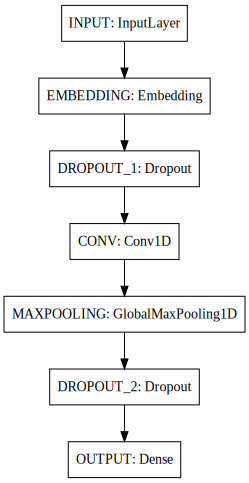

In [152]:
model.summary()
SVG(model_to_dot(model).create(prog='dot', format='svg'))

## Train

In [153]:
filepath = '/Users/lizhn7/Downloads/DATA/chinese_news/mini/co_logs/weights.{epoch:03d}-{val_loss:.6f}.hdf5'
log_string = '/Users/lizhn7/Downloads/DATA/chinese_news/mini/tb_logs/mini'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True)
tensorboard = TensorBoard(log_dir=log_string) 

In [ ]:
history = model.fit(xTrain,
                    yTrain,
                    batch_size=BATCH_SIZE,
                    epochs=NUM_EPOCHS, 
                    verbose=1,
                    callbacks=[checkpoint],
                    validation_data=(xVal, yVal), 
                    shuffle=True)

# Evaluate

In [157]:
threshold = [i/10 for i in range(1, 9, 1)]

In [158]:
def calculate(pred, actu, THRESHOLD=0.5, t=1, f=0):
    """
    Calculate Precision Recall F1-score
    """
    pred = [1 if i >= THRESHOLD else 0 for i in pred]
    actu = sum([list(i) for i in actu], [])
    CTP = sum([1 for i in range(len(pred)) if pred[i] == t and actu[i] == t])
    CFN = sum([1 for i in range(len(pred)) if pred[i] == f and actu[i] == t])
    CFP = sum([1 for i in range(len(pred)) if pred[i] == t and actu[i] == f])
    CTN = sum([1 for i in range(len(pred)) if pred[i] == f and actu[i] == f])
    NCTP = CTN
    NCFN = CFP
    NCFP = CFN
    NCTN = CTP
    CP = CTP/(CTP+CFP)
    CR = CTP/(CTP+CFN)
    CF1 = 2*CP*CR/(CP+CR)
    NCP = NCTP/(NCTP+NCFP)
    NCR = NCTP/(NCTP+NCFN)
    NCF1 = 2*NCP*NCR/(NCP+NCR)
    ACC = (CTP+CTN)/(CTP+CFP+CFN+CTN)
    print('Threshold: \t%.3f' % (THRESHOLD))
    print('Causal: \tPreciion %.3f \tRecall %.3f \tF1-score %.3f' % (CP, CR, CF1))
    print('Non-Causal: \tPreciion %.3f \tRecall %.3f \tF1-score %.3f' % (NCP, NCR, NCF1))
    print('Accuracy: \t%.3f' % (ACC))

In [159]:
filename = '/Users/lizhn7/Downloads/DATA/chinese_news/mini/co_logs/weights.005-0.332273.hdf5'
model.load_weights(filename)
result = model.predict(xVal, batch_size=BATCH_SIZE, verbose=1)

#model.summary()

for THRESHOLD in threshold:
    calculate(result, yVal, THRESHOLD=THRESHOLD)
    print('————————————————————————')
    
#SVG(model_to_dot(model).create(prog='dot', format='svg'))

480/509 [===========================>..] - ETA: 0sThreshold: 	0.100
Causal: 	Preciion 0.547 	Recall 0.992 	F1-score 0.705
Non-Causal: 	Preciion 0.966 	Recall 0.218 	F1-score 0.356
Accuracy: 	0.595
————————————————————————
Threshold: 	0.200
Causal: 	Preciion 0.695 	Recall 0.964 	F1-score 0.807
Non-Causal: 	Preciion 0.945 	Recall 0.598 	F1-score 0.732
Accuracy: 	0.776
————————————————————————
Threshold: 	0.300
Causal: 	Preciion 0.769 	Recall 0.911 	F1-score 0.834
Non-Causal: 	Preciion 0.898 	Recall 0.739 	F1-score 0.811
Accuracy: 	0.823
————————————————————————
Threshold: 	0.400
Causal: 	Preciion 0.814 	Recall 0.867 	F1-score 0.840
Non-Causal: 	Preciion 0.865 	Recall 0.812 	F1-score 0.838
Accuracy: 	0.839
————————————————————————
Threshold: 	0.500
Causal: 	Preciion 0.845 	Recall 0.835 	F1-score 0.840
Non-Causal: 	Preciion 0.845 	Recall 0.854 	F1-score 0.850
Accuracy: 	0.845
————————————————————————
Threshold: 	0.600
Causal: 	Preciion 0.878 	Recall 0.815 	F1-score 0.845
Non-Causal: 	Preci